In [1]:
import pandas as pd
import numpy as np
import itertools
import xgboost
import tensorflow as tf
from scipy.sparse import hstack
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
from keras.callbacks import EarlyStopping
from tqdm import tqdm
tqdm.pandas()
import pickle
import joblib

C:\Users\praveen\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Data input

In [2]:
# df = pd.read_csv('data/reddit_sarcasm.csv').reset_index(drop=True)
df = pd.read_csv('data/reddit_sarcasm.csv').reset_index(drop=True)
df.dropna(subset=['comment'], inplace=True)

## EDA and Visualization

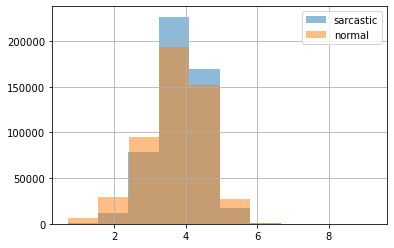

In [3]:
df.loc[df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
df.loc[df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [4]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 1, width=800, height=400)

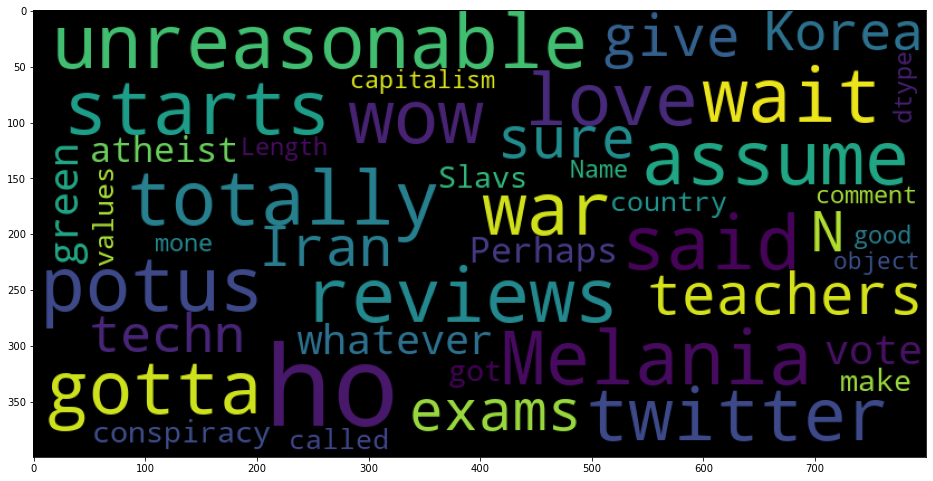

In [5]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['label'] == 1, 'comment']))
plt.imshow(wordcloud)

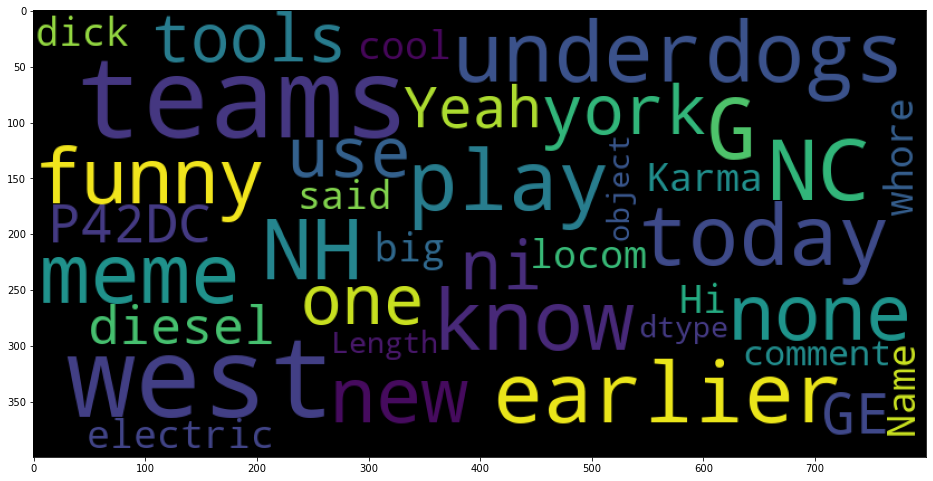

In [9]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(df.loc[df['label'] == 0, 'comment']))
plt.imshow(wordcloud)

In [10]:
def plot_confusion_matrix(actual, predicted, classes,                          
                        normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):

    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')
        

## Test train split

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(df['comment'],df['label'], random_state=17)

## Logistic regression with TFIDF vectorizer - content based approach

In [ ]:
# tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

# logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
#                            random_state=17, verbose=1)

# tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
#                                  ('logit', logit)])
# tfidf_logit_pipeline.fit(X_train, y_train)

In [ ]:
# valid_pred_1 = tfidf_logit_pipeline.predict(X_valid)
# accuracy_score(y_valid, valid_pred_1)

In [13]:
# with open('notebook.pkl','wb') as f:
#     pickle.dump(tfidf_logit_pipeline,f)

In [15]:
model_1 = joblib.load('notebook.pkl')
valid_pred_1 = model_1.predict(X_valid)
accuracy_score(y_valid, valid_pred_1)

0.7209391596159782

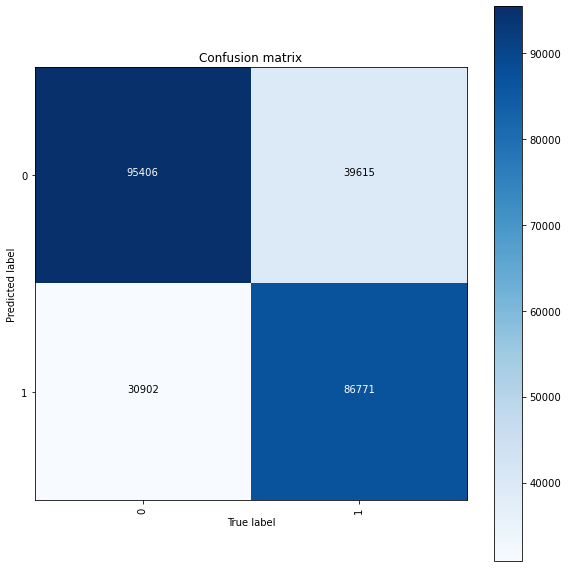

In [17]:

plot_confusion_matrix(y_valid, valid_pred_1, 
                      model_1.named_steps['logit'].classes_, figsize=(8, 8))


## Logistic regression with TFIDF vectorizer - context based approach

In [22]:
if 'subreddit' in list(df.columns):
    subreddits = df['subreddit']
    train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)
    logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs',random_state=17, verbose=1)
    tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
    X_train_texts = tf_idf_texts.fit_transform(X_train)
    X_valid_texts = tf_idf_texts.transform(X_valid)
    tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))
    X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
    X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)
    X_Train = hstack([X_train_texts, X_train_subreddits])
    X_Valid = hstack([X_valid_texts, X_valid_subreddits])
    logit.fit(X_Train, y_train)
    valid_pred_2 = logit.predict(X_Valid)
    print(accuracy_score(y_valid, valid_pred_2))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.6s finished


0.7237844982468915


## XGBoost Classifier with TFIDF vectorizer

In [30]:
xgboost = XGBClassifier()

tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

xgboost_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('xgboost', xgboost)])

xgboost_pipeline.fit(X_train, y_train)

valid_pred = xgboost_pipeline.predict(X_valid)

accuracy_score(y_valid, valid_pred)

[19:19:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6840130751026934

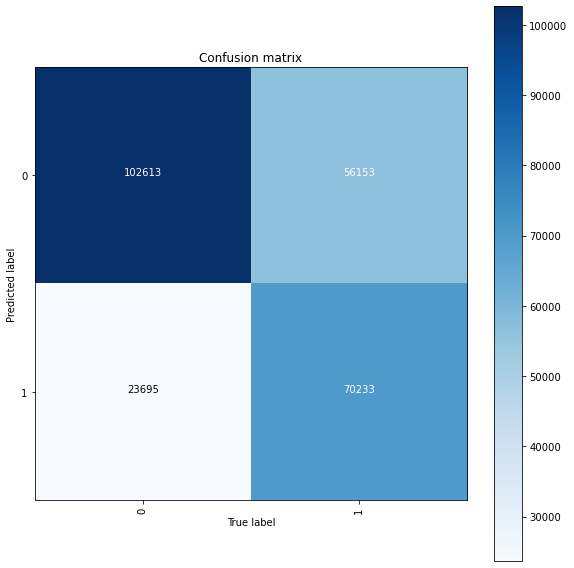

In [32]:
plot_confusion_matrix(y_valid, valid_pred, 
                      xgboost_pipeline.named_steps['xgboost'].classes_, figsize=(8, 8))

## Recurrent Neural Networks using with TFIDF vectorizer

In [33]:
X = df.comment
Y = df.label
le = LabelEncoder() 
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [34]:
X_train1,X_valid1,y_train1,y_valid1 = train_test_split(X,Y,test_size=0.2)

In [35]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train1)
sequences = tok.texts_to_sequences(X_train1)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [36]:

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [37]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [38]:
# model.fit(sequences_matrix,y_train1,batch_size=100,epochs=5,
#           validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/5
7278/7278 [==============================] - 753s 103ms/step - loss: 0.6038 - accuracy: 0.6691 - val_loss: 0.5729 - val_accuracy: 0.6949
Epoch 2/5
7278/7278 [==============================] - 770s 106ms/step - loss: 0.5718 - accuracy: 0.6980 - val_loss: 0.5695 - val_accuracy: 0.6980
Epoch 3/5
7278/7278 [==============================] - 777s 107ms/step - loss: 0.5650 - accuracy: 0.7034 - val_loss: 0.5653 - val_accuracy: 0.7023
Epoch 4/5
7278/7278 [==============================] - 749s 103ms/step - loss: 0.5612 - accuracy: 0.7066 - val_loss: 0.5631 - val_accuracy: 0.7052
Epoch 5/5
7278/7278 [==============================] - 761s 105ms/step - loss: 0.5563 - accuracy: 0.7105 - val_loss: 0.5735 - val_accuracy: 0.7002


In [39]:
test_sequences = tok.texts_to_sequences(X_valid1)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [41]:
# accr = model.evaluate(test_sequences_matrix,y_valid1)
# print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6318/6318 [==============================] - 120s 19ms/step - loss: 0.5727 - accuracy: 0.7009
Test set
  Loss: 0.573
  Accuracy: 0.701


In [51]:
# model.save('nn_model')

INFO:tensorflow:Assets written to: nn_model\assets


INFO:tensorflow:Assets written to: nn_model\assets


In [59]:
loaded_model = tf.keras.models.load_model('nn_model')

In [61]:
accr = loaded_model.evaluate(test_sequences_matrix,y_valid1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6318/6318 [==============================] - 115s 18ms/step - loss: 0.5727 - accuracy: 0.7009
Test set
  Loss: 0.573
  Accuracy: 0.701
